In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rba-dataset/LICENSE
/kaggle/input/rba-dataset/README.md
/kaggle/input/rba-dataset/RESULTS.md
/kaggle/input/rba-dataset/rba-dataset.csv
/kaggle/input/rba-dataset/images/rq1-general.png
/kaggle/input/rba-dataset/images/rq1-login-frequency.png
/kaggle/input/rba-dataset/images/rtts-global.png
/kaggle/input/rba-dataset/images/login-overview.png
/kaggle/input/rba-dataset/images/rtts-continents.png
/kaggle/input/rba-dataset/images/rq6-rtt-0_999.png
/kaggle/input/rba-dataset/images/rq2-attack-data.png


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd

In [3]:
pd.set_option('display.max_rows', None)  # 모든 행을 출력
pd.set_option('display.max_columns', None)  # 모든 열을 출력

In [4]:
raw = pd.read_csv('/kaggle/input/rba-dataset/rba-dataset.csv')

In [5]:
data = raw.drop(['index','ASN', 'User Agent String','Browser Name and Version', 'OS Name and Version', 'Device Type'], axis=1)

In [6]:
data.isnull().sum()

Login Timestamp                0
User ID                        0
Round-Trip Time [ms]    29993329
IP Address                     0
Country                        0
Region                     47409
City                        8590
Login Successful               0
Is Attack IP                   0
Is Account Takeover            0
dtype: int64

In [7]:
len(data)

31269264

In [8]:
# 두 컬럼 중 하나라도 True라면 결과를 True로 설정
data['Is Threat'] = data['Is Account Takeover'] | data['Is Attack IP']

In [9]:
data.head(20)

,Login Timestamp,User ID,Round-Trip Time [ms],IP Address,Country,Region,City,Login Successful,Is Attack IP,Is Account Takeover,Is Threat
0,2020-02-03 12:43:30.772,-4324475583306591935,NaN,10.0.65.171,NO,-,-,False,False,False,False
1,2020-02-03 12:43:43.549,-4324475583306591935,NaN,194.87.207.6,AU,-,-,False,False,False,False
2,2020-02-03 12:43:55.873,-3284137479262433373,NaN,81.167.144.58,NO,Vestland,Urangsvag,True,False,False,False
3,2020-02-03 12:43:56.180,-4324475583306591935,NaN,170.39.78.152,US,-,-,False,False,False,False
4,2020-02-03 12:43:59.396,-4618854071942621186,NaN,10.0.0.47,US,Virginia,Ashburn,False,True,False,True
5,2020-02-03 12:44:05.160,-4324475583306591935,NaN,209.236.123.126,US,-,-,False,True,False,True
6,2020-02-03 12:44:07.893,7246533443898239661,NaN,80.202.228.214,NO,-,-,True,False,False,False
7,2020-02-03 12:44:12.799,-3243978724802435038,NaN,170.39.78.177,US,-,-,False,False,False,False
8,2020-02-03 12:44:17.474,8076000552587369902,NaN,10.0.61.212,NO,-,-,False,False,False,False
9,2020-02-03 12:44:19.071,-3065936140549856249,NaN,92.221.109.162,NO,Rogaland,Sandnes,True,False,False,False


In [10]:
data[data['Country'] =='DM']

,Login Timestamp,User ID,Round-Trip Time [ms],IP Address,Country,Region,City,Login Successful,Is Attack IP,Is Account Takeover,Is Threat
21435971,2020-11-21 07:15:17.017,-4324475583306591935,NaN,10.0.43.102,DM,Saint David,Rosalie,False,True,False,True
21437289,2020-11-21 07:30:00.346,-4324475583306591935,NaN,10.0.43.102,DM,Saint David,Rosalie,False,True,False,True
21437505,2020-11-21 07:32:00.320,-4324475583306591935,NaN,10.0.43.102,DM,Saint David,Rosalie,False,True,False,True
21437550,2020-11-21 07:32:30.077,-4324475583306591935,NaN,10.0.43.27,DM,Saint George,Roseau,False,True,False,True


In [11]:
# 나라별 공격 전체 IP 비율과 개수 계산
grouped_data = data.groupby('Country')['Is Threat']
country_attack_rate = grouped_data.mean().reset_index()
country_attack_count = grouped_data.size().reset_index(name='Count')

# 결과를 병합
result = pd.merge(country_attack_rate, country_attack_count, on='Country')

# 비율을 숫자로 계산
result['Is Threat Rate'] = result['Is Threat'] * 100

# 내림차순으로 숫자 기준 정렬
result = result.sort_values('Is Threat Rate', ascending=False)

# 퍼센트 형식의 문자열 추가
result['Is Threat'] = result['Is Threat Rate'].apply(lambda x: f"{x:.2f}%")

print(result)

    Country Is Threat     Count  Is Threat Rate
55       DM   100.00%         4      100.000000
225      YT    66.67%        12       66.666667
174      RO    49.65%    121535       49.648249
27       BO    43.22%      1939       43.218154
16       BB    42.76%       145       42.758621
197      TG    40.23%        87       40.229885
219      VN    36.11%     20245       36.107681
101      JM    34.70%       438       34.703196
0        AE    33.51%      2325       33.505376
228      ZW    29.86%      1306       29.862175
211      US    27.82%   8685928       27.824672
30       BS    27.07%       351       27.065527
78       GN    26.93%       401       26.932668
42       CL    25.63%     18542       25.628303
144      MW    25.29%      1467       25.289707
12       AW    24.00%        75       24.000000
213      UZ    23.59%      2081       23.594426
172      QA    23.50%       617       23.500810
5        AM    23.17%      2382       23.173804
91       ID    23.12%    304103       23

In [12]:
result['Count'].corr(result['Is Threat Rate'])

0.024110430463469452

In [13]:
# 나라별 공격 전체 IP 비율과 개수 계산
grouped_data = data.groupby(['Country', 'Region'])['Is Threat']
country_attack_rate = grouped_data.mean().reset_index()
country_attack_count = grouped_data.size().reset_index(name='Count')

# 결과를 병합
result2 = pd.merge(country_attack_rate, country_attack_count, on=['Country', 'Region'])

# 비율을 숫자로 계산
result2['Is Threat Rate'] = result2['Is Threat'] * 100

# 내림차순으로 숫자 기준 정렬
result2 = result2.sort_values('Is Threat Rate', ascending=False)

# 퍼센트 형식의 문자열 추가
result2['Is Threat'] = result2['Is Threat Rate'].apply(lambda x: f"{x:.2f}%")

print(result2[:50])

     Country                    Region Is Threat  Count  Is Threat Rate
2591      TR                  Osmaniye   100.00%      5           100.0
872       HK        Yuen Long District   100.00%      2           100.0
2564      TR                   Giresun   100.00%     20           100.0
2606      TR                 Zonguldak   100.00%      1           100.0
2563      TR                 Gaziantep   100.00%     31           100.0
2607      TR                   Çankırı   100.00%      6           100.0
2561      TR                  Erzincan   100.00%      3           100.0
2608      TR                 Şanlıurfa   100.00%     25           100.0
1322      LR              Nimba County   100.00%      6           100.0
2553      TR                    Burdur   100.00%      2           100.0
864       HK              Sham Shui Po   100.00%      5           100.0
1355      LV                    Aglona   100.00%      1           100.0
125       BB             Christ Church   100.00%      6         

In [14]:
# 'Is Threat Rate'를 10% 구간으로 나누기
result2['Threat Rate Category'] = pd.cut(result2['Is Threat Rate'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
                                      labels=['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%'])

# 각 범주별로 국가별 등장 횟수 계산
category_country_counts = result2.groupby(['Threat Rate Category', 'Country']).size().reset_index(name='Count')

In [15]:
category_country_counts[category_country_counts['Count'] != 0]

,Threat Rate Category,Country,Count
0,0-10%,AE,1
1,0-10%,AF,2
4,0-10%,AL,1
5,0-10%,AM,1
6,0-10%,AO,1
8,0-10%,AR,5
10,0-10%,AT,6
11,0-10%,AU,3
14,0-10%,AZ,1
15,0-10%,BA,1


In [16]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

/tmp/ipykernel_19/3926210268.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [17]:
# 'iso_a3'에서 마지막 문자 제거하여 'iso_a2' 형식으로 변환
world['iso_a2'] = world['iso_a3'].str[:-1]

# 데이터셋의 국가 코드 컬럼 이름이 'Country'라고 가정
merged = world.set_index('iso_a2').join(result.set_index('Country'))


In [18]:
merged.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,Is Threat,Count,Is Threat Rate
iso_a2,,,,,,,,,
-9,1794248.0,Europe,Kosovo,-99,7926,"POLYGON ((20.59025 41.85541, 20.52295 42.21787...",NaN,NaN,NaN
AF,38041754.0,Asia,Afghanistan,AFG,19291,"POLYGON ((66.51861 37.36278, 67.07578 37.35614...",11.48%,2291.0,11.479703
AG,31825295.0,Africa,Angola,AGO,88815,"MULTIPOLYGON (((12.99552 -4.78110, 12.63161 -4...",0.00%,241.0,0.000000
AL,2854191.0,Europe,Albania,ALB,15279,"POLYGON ((21.02004 40.84273, 20.99999 40.58000...",19.26%,2892.0,19.260028
AR,44938712.0,South America,Argentina,ARG,445445,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000...",3.17%,133202.0,3.171124


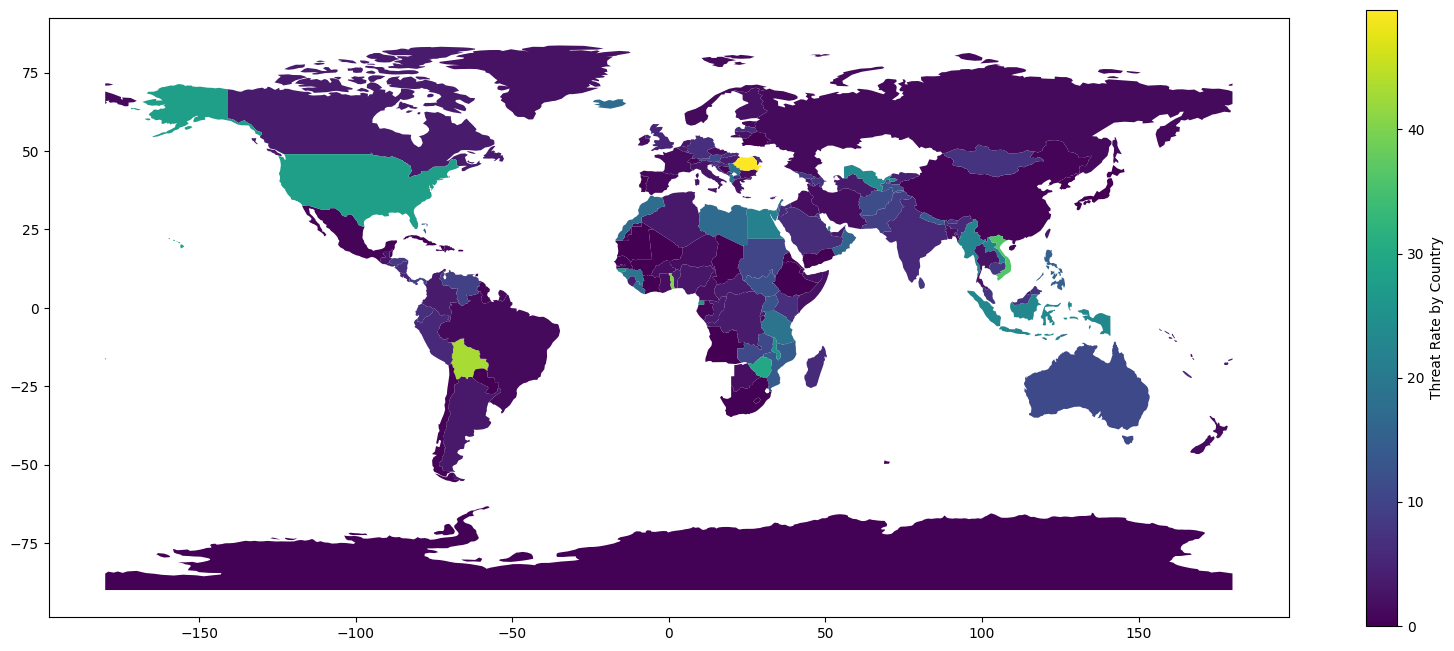

In [19]:
# 지도에 데이터 시각화
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
merged.plot(column='Is Threat Rate', ax=ax, legend=True, legend_kwds={'label': "Threat Rate by Country"})

plt.show()

In [20]:
Round_cleaned = data.dropna(subset=['Round-Trip Time [ms]'])

In [21]:
Round_cleaned.groupby('Is Threat')['Round-Trip Time [ms]'].mean()

Is Threat
False    662.178166
True     773.223346
Name: Round-Trip Time [ms], dtype: float64

In [22]:
# IP 주소가 이전 행과 동일한 경우만 필터링
filtered_data = data[data['IP Address'].eq(data['IP Address'].shift()) | data['IP Address'].eq(data['IP Address'].shift(-1))]

filtered_data[:50]

,Login Timestamp,User ID,Round-Trip Time [ms],IP Address,Country,Region,City,Login Successful,Is Attack IP,Is Account Takeover,Is Threat
240,2020-02-03 12:47:32.052,-4324475583306591935,NaN,194.152.35.141,RU,Moscow,Moscow,False,True,False,True
241,2020-02-03 12:47:33.165,-4324475583306591935,NaN,194.152.35.141,RU,Moscow,Moscow,False,True,False,True
280,2020-02-03 12:48:00.375,-4324475583306591935,NaN,10.1.38.113,IN,Maharashtra,Mumbai,False,False,False,False
281,2020-02-03 12:48:01.120,-4324475583306591935,NaN,10.1.38.113,IN,Maharashtra,Mumbai,False,False,False,False
815,2020-02-03 12:55:03.044,-4324475583306591935,NaN,103.69.113.0,IN,Maharashtra,Thane,False,False,False,False
816,2020-02-03 12:55:04.004,-4324475583306591935,NaN,103.69.113.0,IN,Maharashtra,Thane,False,False,False,False
947,2020-02-03 12:56:36.322,-4324475583306591935,NaN,188.116.36.69,AU,-,-,False,True,False,True
948,2020-02-03 12:56:37.629,-5180418108068744021,NaN,188.116.36.69,AU,-,-,False,True,False,True
1469,2020-02-03 13:03:05.501,-2118107195389570521,NaN,10.0.68.244,NO,Innlandet,Raufoss,True,False,False,False
1470,2020-02-03 13:03:06.295,-4324475583306591935,NaN,10.0.68.244,NO,Innlandet,Raufoss,False,False,False,False


In [23]:
filtered_data['Is Threat'].value_counts()

Is Threat
False    511684
True      85305
Name: count, dtype: int64

In [24]:
data['Is Threat'].value_counts()

Is Threat
False    28172223
True      3097041
Name: count, dtype: int64